In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import plotly
import plotly.express as px
import plotly.graph_objs as go
from plotly.offline import init_notebook_mode, plot, iplot
import cv2
import random
import os
import glob
import tensorflow.keras
import seaborn as sns
from tensorflow.keras.applications.resnet50 import ResNet50
from keras_applications import xception
from tqdm.notebook import tqdm
import albumentations as A
import tensorflow as tf
from tensorflow.keras.layers import Conv2D, Flatten, MaxPooling2D, Dense, Dropout , BatchNormalization
from tensorflow.keras.models import Sequential
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.vgg16 import VGG16
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report,confusion_matrix
from sklearn.metrics import roc_curve, roc_auc_score, auc

from sklearn.utils.multiclass import unique_labels
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, fbeta_score, classification_report
from sklearn.metrics import roc_curve, precision_recall_curve, roc_auc_score
from tensorflow.keras.callbacks import ReduceLROnPlateau
import torch
import warnings
warnings.filterwarnings('ignore')
warnings.simplefilter('ignore')
import time


ModuleNotFoundError: No module named 'torch'

In [ ]:
device=torch.device('cuda')
print('Num GPUs available', len(tf.config.experimental.list_physical_devices('GPU')))

Num GPUs available 1


In [ ]:
cwd=os.getcwd()
wd=cwd+'/chest_xray'

In [ ]:
train_data=glob.glob(wd+'/train/**/*.jpeg')
test_data=glob.glob(wd+'/test/**/*.jpeg')
val_data=glob.glob(wd+'/val/**/*.jpeg')

In [ ]:
print("//"*20)
print(f"Training Set has: {len(train_data)} images")
print(f"Testing Set has: {len(test_data)} images")
print(f"Validation Set has: {len(val_data)} images")
print("//"*20)

////////////////////////////////////////
Training Set has: 5216 images
Testing Set has: 624 images
Validation Set has: 16 images
////////////////////////////////////////


In [ ]:
sets = ["train", "test", "val"]
all_pneumonia = []
all_normal = []
results={}
results['model']=[]
results['total_param']=[]
results['time']=[]
results['score']=[]

for cat in sets:
    path = os.path.join(wd, cat)
    norm = glob.glob(os.path.join(path, "NORMAL/*.jpeg"))
    pneu = glob.glob(os.path.join(path, "PNEUMONIA/*.jpeg"))
    all_normal.extend(norm)
    all_pneumonia.extend(pneu)
print("〰"*20)
print(f"Total Pneumonia Images: {len(all_pneumonia)}")
print(f"Total Normal Images: {len(all_normal)}")
print("〰"*20)

〰〰〰〰〰〰〰〰〰〰〰〰〰〰〰〰〰〰〰〰
Total Pneumonia Images: 4273
Total Normal Images: 1583
〰〰〰〰〰〰〰〰〰〰〰〰〰〰〰〰〰〰〰〰


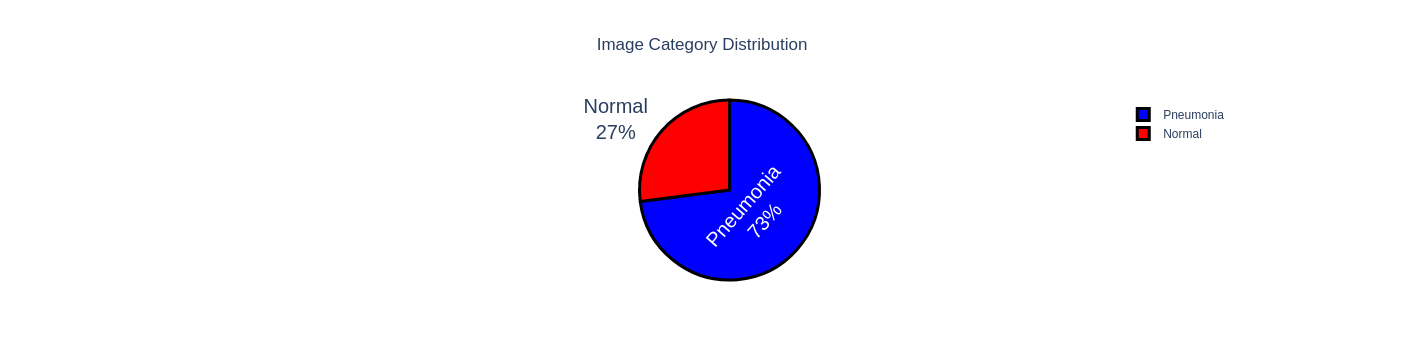

In [ ]:
## Plotly chart for Class distribution
labels = ["Normal",'Pneumonia ']
values = [len(all_normal), len(all_pneumonia)]
colors = ['red', 'blue']
fig = go.Figure(data=[go.Pie(labels=labels,
                             values=values)])
fig.update_traces(hoverinfo='value', textinfo='label+percent', textfont_size=20,
                  marker=dict(colors=colors, line=dict(color='#000000', width=3)))
fig.update_layout(title="Image Category Distribution", title_x=0.5)
iplot(fig)

In [ ]:
random.shuffle(all_normal)
random.shuffle(all_pneumonia)
images = all_normal[:11] + all_pneumonia[:10]

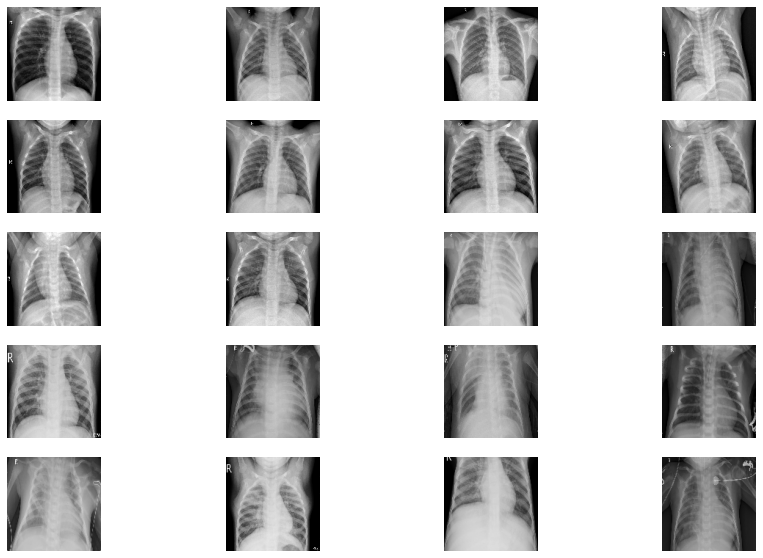

In [ ]:
fig=plt.figure(figsize=(15, 10))
columns = 4; rows = 5
for i in range(1, columns*rows+1):
    img = cv2.imread(images[i])
    img = cv2.resize(img, (128, 128))
    fig.add_subplot(rows, columns, i)
    plt.imshow(img)
    plt.axis(False)

# Base Model

In [ ]:
#data augmentation
train_gen = ImageDataGenerator(
        rescale=1/255.,
        featurewise_center=False,  # set input mean to 0 over the dataset
        samplewise_center=False,  # set each sample mean to 0
        featurewise_std_normalization=False,  # divide inputs by std of the dataset
        samplewise_std_normalization=False,  # divide each input by its std
        zca_whitening=False,  # apply ZCA whitening
        rotation_range = 30,  # randomly rotate images in the range (degrees, 0 to 180)
        zoom_range = 0.4, # Randomly zoom image 
        width_shift_range=0.1,  # randomly shift images horizontally (fraction of total width)
        height_shift_range=0.1,  # randomly shift images vertically (fraction of total height)
        horizontal_flip = True,  # randomly flip images
        vertical_flip=False,
        validation_split=0.2) #validation size
test_gen=ImageDataGenerator(
        rescale=1/255.,
        featurewise_center=False,  # set input mean to 0 over the dataset
        samplewise_center=False,  # set each sample mean to 0
        featurewise_std_normalization=False,  # divide inputs by std of the dataset
        samplewise_std_normalization=False,  # divide each input by its std
        zca_whitening=False,  # apply ZCA whitening
        horizontal_flip = False,  # randomly flip images
        vertical_flip=False)  # randomly flip images


In [ ]:
batch_size=64
nb_epochs=90
train_generator = train_gen.flow_from_directory(
    wd+"/train",
    batch_size=batch_size,
    target_size=(224, 224), #class_mode="binary"
  #  class_mode='binary',
    subset='training'                                            
)

validation_generator = train_gen.flow_from_directory(
    wd+"/train", # same directory as training data
    batch_size=batch_size,
    target_size=(224, 224),
 #   class_mode='binary',
    subset='validation') # set as validation data
test_generator=test_gen.flow_from_directory(
    wd+"/test", # same directory as training data
    batch_size=1,
    target_size=(224, 224),
    shuffle=False)



Found 4173 images belonging to 2 classes.
Found 1043 images belonging to 2 classes.
Found 624 images belonging to 2 classes.


In [ ]:
model = Sequential()
model.add(Conv2D(32,(3,3),strides=(1, 1),activation='relu',padding='same', input_shape=(224, 224, 3)))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Conv2D(64,(3,3),strides=(1, 1) ,padding='same',activation='relu'))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Conv2D(128,(3,3),strides=(1, 1),padding='same', activation='relu'))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Conv2D(256,(3,3),strides=(1, 1),padding='same', activation='relu'))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Flatten())

model.add(Dense(128, activation='relu'))
model.add(Dense(64, activation='relu'))
model.add(Dense(2, activation='softmax'))
model.summary()

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_16 (Conv2D)           (None, 224, 224, 32)      896       
_________________________________________________________________
max_pooling2d_16 (MaxPooling (None, 112, 112, 32)      0         
_________________________________________________________________
conv2d_17 (Conv2D)           (None, 112, 112, 64)      18496     
_________________________________________________________________
max_pooling2d_17 (MaxPooling (None, 56, 56, 64)        0         
_________________________________________________________________
conv2d_18 (Conv2D)           (None, 56, 56, 128)       73856     
_________________________________________________________________
max_pooling2d_18 (MaxPooling (None, 28, 28, 128)       0         
_________________________________________________________________
conv2d_19 (Conv2D)           (None, 28, 28, 256)      

In [ ]:
## Compile the model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [ ]:
early_stopping_cb = tf.keras.callbacks.EarlyStopping(patience=5,restore_best_weights=True)
start=time.time()
history_base = model.fit_generator(
    train_generator,
    epochs = nb_epochs,
    validation_data=validation_generator,
    steps_per_epoch=train_generator.samples // batch_size,
    validation_steps = validation_generator.samples // batch_size,
    callbacks=[early_stopping_cb],
    verbose=1)
run_time=time.time()-start

Epoch 1/90
65/65 [==============================] - 73s 1s/step - loss: 0.6386 - accuracy: 0.6670 - val_loss: 0.4465 - val_accuracy: 0.7695
Epoch 2/90
65/65 [==============================] - 72s 1s/step - loss: 0.4128 - accuracy: 0.8038 - val_loss: 0.4406 - val_accuracy: 0.8076
Epoch 3/90
65/65 [==============================] - 72s 1s/step - loss: 0.3380 - accuracy: 0.8420 - val_loss: 0.3415 - val_accuracy: 0.8281
Epoch 4/90
65/65 [==============================] - 72s 1s/step - loss: 0.3384 - accuracy: 0.8502 - val_loss: 0.3706 - val_accuracy: 0.8125
Epoch 5/90
65/65 [==============================] - 72s 1s/step - loss: 0.3088 - accuracy: 0.8628 - val_loss: 0.3360 - val_accuracy: 0.8369
Epoch 6/90
65/65 [==============================] - 72s 1s/step - loss: 0.2778 - accuracy: 0.8751 - val_loss: 0.3408 - val_accuracy: 0.8281
Epoch 7/90
65/65 [==============================] - 73s 1s/step - loss: 0.2877 - accuracy: 0.8818 - val_loss: 0.2947 - val_accuracy: 0.8721
Epoch 8/90
65/65 [==

In [ ]:
score = model.evaluate_generator(test_generator,  verbose=0)
print('Test score:', score[0])
print('Test accuracy:', score[1])

Test score: 0.4663000702857971
Test accuracy: 0.807692289352417


In [ ]:
#saving the model and histories
#tf.keras.models.save_model(filepath=cwd, model=model)
model.save(cwd+'/assets/model_base')
np.save(cwd+'/assets/history_base.npy', history_base.history)
results['model'].append('base_model')
results['total_param'].append(6819458)
results['time'].append(run_time)
results['score'].append(score[1])

INFO:tensorflow:Assets written to: /home/jovyan/work/fc_project/assets/model_base/assets


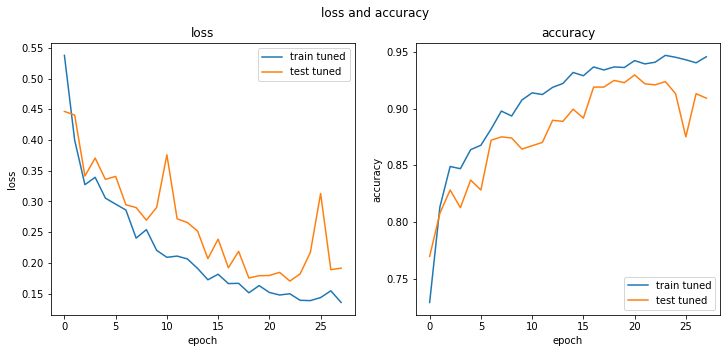

In [ ]:
fig, (ax1, ax2) = plt.subplots(1,2, figsize=(12,5))

ax1.plot(history_base.history['loss'])
ax1.plot(history_base.history['val_loss'])
ax1.set_title('loss')
ax1.set_ylabel('loss')
ax1.set_xlabel('epoch')
ax1.legend(['train tuned', 'test tuned','train','test'], loc='upper right')
ax2.plot(history_base.history['accuracy'])
ax2.plot(history_base.history['val_accuracy'])

ax2.set_title('accuracy')
ax2.set_ylabel('accuracy')
ax2.set_xlabel('epoch')
ax2.legend(['train tuned', 'test tuned','train','test'], loc='lower right')
fig.suptitle('loss and accuracy')
plt.show()

In [ ]:
STEP_SIZE_TEST=624
test_generator.reset()
preds = model.predict(test_generator,
steps=STEP_SIZE_TEST,
verbose=1)

624/624 [==============================] - 7s 7ms/step


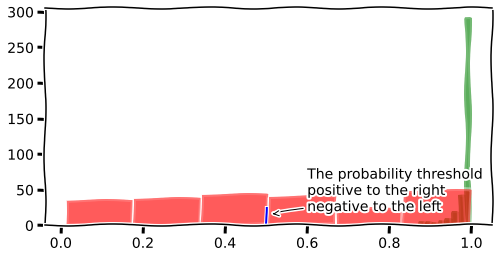

In [ ]:
#scale the output of the model to [0,1]
#scaled_preds=(preds[:,1]-min(preds[:,1]))/(max(preds[:,1])-min(preds[:,1]))
pos = [i for i, j in zip(preds[:,1], test_generator.classes) if j == 1]
neg = [i for i, j in zip(preds[:,1], test_generator.classes) if j == 0]

with plt.xkcd():
  fig = plt.figure(figsize=(8, 4))

  sns.distplot(pos, hist = True, kde = False, color='g',
                 kde_kws = {'shade': True, 'linewidth': 3})

  sns.distplot(neg, hist = True, kde = False, color='r',
                 kde_kws = {'shade': True, 'linewidth': 3})

  plt.plot([0.5, 0.5], [0, 25], '-b')
  plt.annotate(
        'The probability threshold\npositive to the right\nnegative to the left',
        xy=(0.51, 15), arrowprops=dict(arrowstyle='->'), xytext=(0.6, 20))

plt.show()

In [ ]:
def plot_confusion_matrix(cm,
                          target_names,
                          title='Confusion matrix',
                          cmap=None,
                          normalize=True):
    """
    Given a scikit-learn confusion matrix (CM), make a nice plot.

    Arguments

   ---------
    cm:           Confusion matrix from sklearn.metrics.confusion_matrix

    target_names: Given classification classes, such as [0, 1, 2]
                  The class names, for example, ['high', 'medium', 'low']

    title:        The text to display at the top of the matrix

    cmap:         The gradient of the values displayed from matplotlib.pyplot.cm
                  See http://matplotlib.org/examples/color/colormaps_reference.html
                  `plt.get_cmap('jet')` or `plt.cm.Blues`

    normalize:    If `False`, plot the raw numbers
                  If `True`, plot the proportions

    Usage
    -----
    plot_confusion_matrix(cm           = cm,                  # Confusion matrix created by
                                                              # `sklearn.metrics.confusion_matrix`
                          normalize    = True,                # Show proportions
                          target_names = y_labels_vals,       # List of names of the classes
                          title        = best_estimator_name) # Title of graph

    Citation
    ---------
    http://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html

    """
    import matplotlib.pyplot as plt
    import numpy as np
    import itertools

    accuracy = np.trace(cm) / float(np.sum(cm))
    misclass = 1 - accuracy

    if cmap is None:
        cmap = plt.get_cmap('Blues')
    plt.figure(figsize=(8, 6))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()

    if target_names is not None:
        tick_marks = np.arange(len(target_names))
        plt.xticks(tick_marks, target_names, rotation=45)
        plt.yticks(tick_marks, target_names)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]


    thresh = cm.max() / 1.5 if normalize else cm.max() / 2
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        if normalize:
            plt.text(j, i, "{:0.4f}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")
        else:
            plt.text(j, i, "{:,}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")


    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label\naccuracy={:0.4f}; misclass={:0.4f}'.format(accuracy, misclass))
    plt.show()

In [ ]:
confusion = confusion_matrix(test_generator.classes, np.where(preds[:,1]>0.5,1,0), labels=[1, 0])
print(confusion)


[[386   4]
 [116 118]]


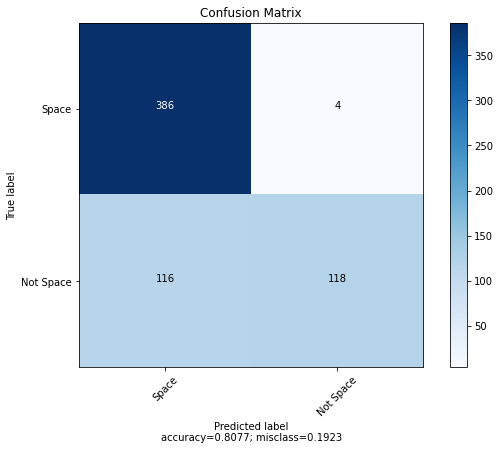

In [ ]:
plot_confusion_matrix(cm=confusion, target_names = ['Space', 'Not Space'], title = 'Confusion Matrix',normalize=False)

In [ ]:
from sklearn.metrics import classification_report

target_names = ['negative', 'positive']
print(classification_report(test_generator.classes, np.where(preds[:,1]>0.5,1,0) , target_names=target_names))

              precision    recall  f1-score   support

    negative       0.97      0.50      0.66       234
    positive       0.77      0.99      0.87       390

    accuracy                           0.81       624
   macro avg       0.87      0.75      0.76       624
weighted avg       0.84      0.81      0.79       624



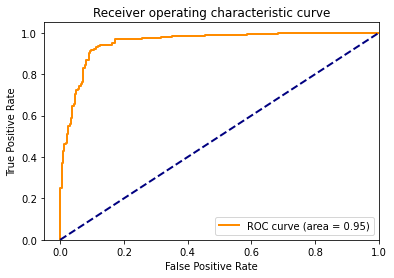

In [ ]:
fpr, tpr, _ = roc_curve(test_generator.classes, preds[:,1])
roc_auc = auc(fpr, tpr)
plt.figure()
lw = 2
plt.plot(fpr, tpr, color='darkorange',
lw=lw, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([-0.05, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic curve')
plt.legend(loc="lower right")
plt.show()

# Xception

In [ ]:
#data augmentation
train_gen = ImageDataGenerator(
        rescale=1/255.,
        featurewise_center=False,  # set input mean to 0 over the dataset
        samplewise_center=False,  # set each sample mean to 0
        featurewise_std_normalization=False,  # divide inputs by std of the dataset
        samplewise_std_normalization=False,  # divide each input by its std
        zca_whitening=False,  # apply ZCA whitening
        rotation_range = 30,  # randomly rotate images in the range (degrees, 0 to 180)
        zoom_range = 0.4, # Randomly zoom image 
        width_shift_range=0.1,  # randomly shift images horizontally (fraction of total width)
        height_shift_range=0.1,  # randomly shift images vertically (fraction of total height)
        horizontal_flip = True,  # randomly flip images
        vertical_flip=False,
        validation_split=0.2) #validation size
test_gen=ImageDataGenerator(
        rescale=1/255.,
        featurewise_center=False,  # set input mean to 0 over the dataset
        samplewise_center=False,  # set each sample mean to 0
        featurewise_std_normalization=False,  # divide inputs by std of the dataset
        samplewise_std_normalization=False,  # divide each input by its std
        zca_whitening=False,  # apply ZCA whitening
        horizontal_flip = False,  # randomly flip images
        vertical_flip=False)  # randomly flip images

In [ ]:
batch_size=16
nb_epochs=90
train_generator = train_gen.flow_from_directory(
    wd+"/train",
    batch_size=batch_size,
    target_size=(224, 224), #class_mode="binary"
  #  class_mode='binary',
    subset='training'                                            
)

validation_generator = train_gen.flow_from_directory(
    wd+"/train", # same directory as training data
    batch_size=batch_size,
    target_size=(224, 224),
 #   class_mode='binary',
    subset='validation') # set as validation data
test_generator=test_gen.flow_from_directory(
    wd+"/test", # same directory as training data
    batch_size=1,
    target_size=(224, 224),
    shuffle=False)

Found 4173 images belonging to 2 classes.
Found 1043 images belonging to 2 classes.
Found 624 images belonging to 2 classes.


In [ ]:
##First, instantiate a base model with pre-trained weights.
base_model = tf.keras.applications.Xception(
    weights="imagenet",  # Load weights pre-trained on ImageNet.
    input_shape=(224, 224, 3),
    include_top=False,
)  # Do not include the ImageNet classifier at the top.

# Freeze the base_model
base_model.trainable = False

# Create new model on top
inputs = tf.keras.Input(shape=(224, 224, 3))
#x = tf.data_augmentation(inputs)  # Apply random data augmentation

# Pre-trained Xception weights requires that input be normalized
# from (0, 255) to a range (-1., +1.), the normalization layer
# does the following, outputs = (inputs - mean) / sqrt(var)
norm_layer = tf.keras.layers.experimental.preprocessing.Normalization()
mean = np.array([0.5] * 3)
var = mean ** 2
# Scale inputs to [-1, +1]
x = norm_layer(inputs)
norm_layer.set_weights([mean, var])
# The base model contains batchnorm layers. We want to keep them in inference mode
# when we unfreeze the base model for fine-tuning, so we make sure that the
# base_model is running in inference mode here.
x = base_model(x, training=False)
x = tf.keras.layers.GlobalAveragePooling2D()(x)
x = tf.keras.layers.Dropout(0.2)(x)  # Regularize with dropout
outputs = tf.keras.layers.Dense(1)(x)
model_base = tf.keras.Model(inputs, outputs)

early_stopping_cb = tf.keras.callbacks.EarlyStopping(patience=10,restore_best_weights=True)
model=Sequential()
model.add(model_base)
model.add(Flatten())

model.add(Dense(128,activation='relu'))
model.add(Dense(64,activation='relu'))
model.add(Dense(2,activation='softmax'))

## Freezing the layers
#for layer in base_model.layers:
 #   layer.trainable=False

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

model_base.summary()
start=time.time()
history_xception = model.fit_generator(train_generator,epochs=90,validation_data=validation_generator,steps_per_epoch=260,callbacks=[early_stopping_cb])
run_1=time.time()-start

Model: "model_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_11 (InputLayer)        [(None, 224, 224, 3)]     0         
_________________________________________________________________
normalization_4 (Normalizati (None, 224, 224, 3)       7         
_________________________________________________________________
xception (Functional)        (None, 7, 7, 2048)        20861480  
_________________________________________________________________
global_average_pooling2d_5 ( (None, 2048)              0         
_________________________________________________________________
dropout_8 (Dropout)          (None, 2048)              0         
_________________________________________________________________
dense_34 (Dense)             (None, 1)                 2049      
Total params: 20,863,536
Trainable params: 2,049
Non-trainable params: 20,861,487
___________________________________________

In [ ]:
# Unfreeze the base_model. Note that it keeps running in inference mode
# since we passed `training=False` when calling it. This means that
# the batchnorm layers will not update their batch statistics.
# This prevents the batchnorm layers from undoing all the training
# we've done so far.
base_model.trainable = True
model.summary()

model.compile(
    optimizer=tf.keras.optimizers.Adam(1e-5),  # Low learning rate
    loss='categorical_crossentropy',
    metrics=['accuracy'],
)

epochs = 10

Model: "sequential_10"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
model_4 (Functional)         (None, 1)                 20863536  
_________________________________________________________________
flatten_10 (Flatten)         (None, 1)                 0         
_________________________________________________________________
dense_35 (Dense)             (None, 128)               256       
_________________________________________________________________
dense_36 (Dense)             (None, 64)                8256      
_________________________________________________________________
dense_37 (Dense)             (None, 2)                 130       
Total params: 20,872,178
Trainable params: 20,817,643
Non-trainable params: 54,535
_________________________________________________________________


In [ ]:
start=time.time()
history_xception_tuning = model.fit_generator(train_generator,epochs=10,validation_data=validation_generator)
runtime=time.time()-start+run_1

Epoch 1/10
261/261 [==============================] - 90s 335ms/step - loss: 0.1605 - accuracy: 0.9443 - val_loss: 0.1123 - val_accuracy: 0.9501
Epoch 2/10
261/261 [==============================] - 88s 335ms/step - loss: 0.1147 - accuracy: 0.9554 - val_loss: 0.1328 - val_accuracy: 0.9463
Epoch 3/10
261/261 [==============================] - 88s 335ms/step - loss: 0.0929 - accuracy: 0.9653 - val_loss: 0.0914 - val_accuracy: 0.9664
Epoch 4/10
261/261 [==============================] - 88s 337ms/step - loss: 0.0837 - accuracy: 0.9693 - val_loss: 0.0811 - val_accuracy: 0.9703
Epoch 5/10
261/261 [==============================] - 88s 338ms/step - loss: 0.0854 - accuracy: 0.9664 - val_loss: 0.0745 - val_accuracy: 0.9693
Epoch 6/10
261/261 [==============================] - 88s 337ms/step - loss: 0.0775 - accuracy: 0.9691 - val_loss: 0.0560 - val_accuracy: 0.9789
Epoch 7/10
261/261 [==============================] - 88s 338ms/step - loss: 0.0596 - accuracy: 0.9765 - val_loss: 0.0603 - val_ac

In [ ]:
score = model.evaluate(test_generator,  verbose=0)
print('Test score:', score[0])
print('Test accuracy:', score[1])

Test score: 0.1737084835767746
Test accuracy: 0.932692289352417


In [ ]:
#saving the model and histories
#tf.keras.models.save_model(filepath=cwd, model=model)
model.save(cwd+'/assets/model_xception')
np.save(cwd+'/assets/history_xception.npy', history_xception.history)
np.save(cwd+'/assets/history_xception_tuning.npy', history_xception_tuning.history)
results['model'].append('Xception2')
results['total_param'].append(20863536)
results['time'].append(runtime)
results['score'].append(score[1])
np.save(cwd+'/assets/results.npy', results)


INFO:tensorflow:Assets written to: /home/jovyan/work/fc_project/assets/model_xception/assets


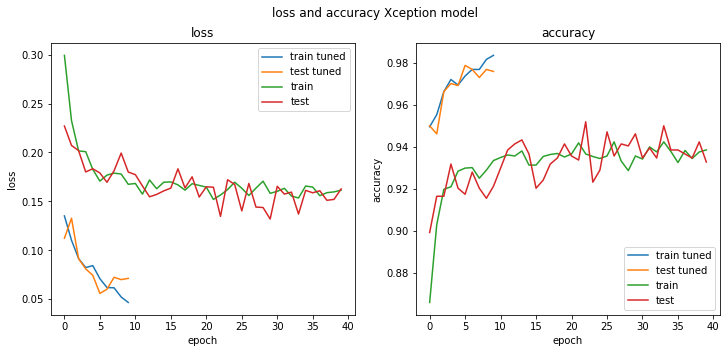

In [ ]:
fig, (ax1, ax2) = plt.subplots(1,2, figsize=(12,5))
ax1.plot(history_xception_tuning.history['loss'])
ax1.plot(history_xception_tuning.history['val_loss'])
ax1.plot(history_xception.history['loss'])
ax1.plot(history_xception.history['val_loss'])
ax1.set_title('loss')
ax1.set_ylabel('loss')
ax1.set_xlabel('epoch')
ax1.legend(['train tuned', 'test tuned','train','test'], loc='upper right')
ax2.plot(history_xception_tuning.history['accuracy'])
ax2.plot(history_xception_tuning.history['val_accuracy'])
ax2.plot(history_xception.history['accuracy'])
ax2.plot(history_xception.history['val_accuracy'])

ax2.set_title('accuracy')
ax2.set_ylabel('accuracy')
ax2.set_xlabel('epoch')
ax2.legend(['train tuned', 'test tuned','train','test'], loc='lower right')
fig.suptitle('loss and accuracy Xception model')
plt.show()

In [ ]:
STEP_SIZE_TEST=test_generator.n//test_generator.batch_size
test_generator.reset()
preds = model.predict(test_generator,
steps=STEP_SIZE_TEST,
verbose=1)

624/624 [==============================] - 6s 9ms/step


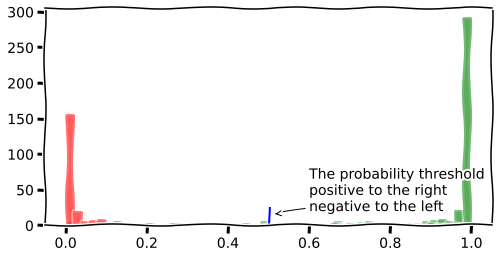

In [ ]:
#scale the output of the model to [0,1]
#scaled_preds=(preds[:,1]-min(preds[:,1]))/(max(preds[:,1])-min(preds[:,1]))
pos = [i for i, j in zip(preds[:,1], test_generator.classes) if j == 1]
neg = [i for i, j in zip(preds[:,1], test_generator.classes) if j == 0]

with plt.xkcd():
  fig = plt.figure(figsize=(8, 4))

  sns.distplot(pos, hist = True, kde = False, color='g',
                 kde_kws = {'shade': True, 'linewidth': 3})

  sns.distplot(neg, hist = True, kde = False, color='r',
                 kde_kws = {'shade': True, 'linewidth': 3})

  plt.plot([0.5, 0.5], [0, 25], '-b')
  plt.annotate(
        'The probability threshold\npositive to the right\nnegative to the left',
        xy=(0.51, 15), arrowprops=dict(arrowstyle='->'), xytext=(0.6, 20))

plt.show()

In [ ]:
confusion = confusion_matrix(test_generator.classes, np.where(preds[:,1]>0.5,1,0), labels=[1, 0])
print(confusion)

[[369  21]
 [ 21 213]]


In [ ]:
def plot_confusion_matrix(cm,
                          target_names,
                          title='Confusion matrix',
                          cmap=None,
                          normalize=True):
    """
    Given a scikit-learn confusion matrix (CM), make a nice plot.

    Arguments

   ---------
    cm:           Confusion matrix from sklearn.metrics.confusion_matrix

    target_names: Given classification classes, such as [0, 1, 2]
                  The class names, for example, ['high', 'medium', 'low']

    title:        The text to display at the top of the matrix

    cmap:         The gradient of the values displayed from matplotlib.pyplot.cm
                  See http://matplotlib.org/examples/color/colormaps_reference.html
                  `plt.get_cmap('jet')` or `plt.cm.Blues`

    normalize:    If `False`, plot the raw numbers
                  If `True`, plot the proportions

    Usage
    -----
    plot_confusion_matrix(cm           = cm,                  # Confusion matrix created by
                                                              # `sklearn.metrics.confusion_matrix`
                          normalize    = True,                # Show proportions
                          target_names = y_labels_vals,       # List of names of the classes
                          title        = best_estimator_name) # Title of graph

    Citation
    ---------
    http://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html

    """
    import matplotlib.pyplot as plt
    import numpy as np
    import itertools

    accuracy = np.trace(cm) / float(np.sum(cm))
    misclass = 1 - accuracy

    if cmap is None:
        cmap = plt.get_cmap('Blues')
    plt.figure(figsize=(8, 6))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()

    if target_names is not None:
        tick_marks = np.arange(len(target_names))
        plt.xticks(tick_marks, target_names, rotation=45)
        plt.yticks(tick_marks, target_names)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]


    thresh = cm.max() / 1.5 if normalize else cm.max() / 2
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        if normalize:
            plt.text(j, i, "{:0.4f}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")
        else:
            plt.text(j, i, "{:,}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")


    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label\naccuracy={:0.4f}; misclass={:0.4f}'.format(accuracy, misclass))
    plt.show()

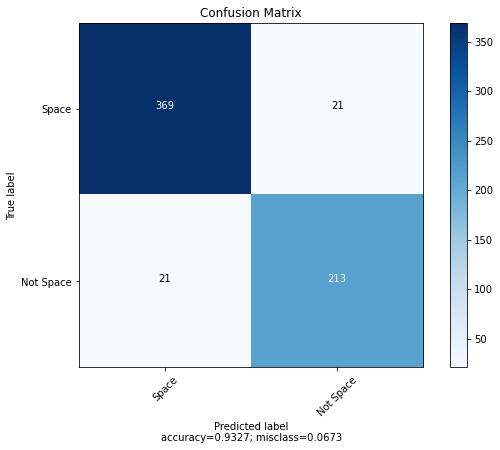

In [ ]:
plot_confusion_matrix(cm=confusion, target_names = ['Space', 'Not Space'], title = 'Confusion Matrix',normalize=False)

In [ ]:
from sklearn.metrics import classification_report

target_names = ['negative', 'positive']
print(classification_report(test_generator.classes, np.where(preds[:,1]>0.5,1,0) , target_names=target_names))

              precision    recall  f1-score   support

    negative       0.91      0.91      0.91       234
    positive       0.95      0.95      0.95       390

    accuracy                           0.93       624
   macro avg       0.93      0.93      0.93       624
weighted avg       0.93      0.93      0.93       624



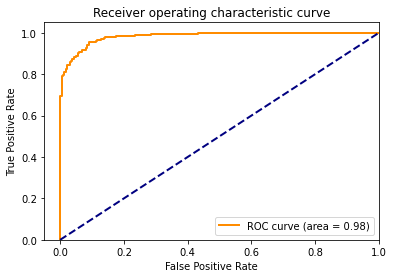

In [ ]:
fpr, tpr, _ = roc_curve(test_generator.classes, preds[:,1])
roc_auc = auc(fpr, tpr)
plt.figure()
lw = 2
plt.plot(fpr, tpr, color='darkorange',
lw=lw, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([-0.05, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic curve')
plt.legend(loc="lower right")
plt.show()

# RESNET50

In [ ]:
#data augmentation
train_gen = ImageDataGenerator(
    #    rescale=1/255,
        dtype = 'float32',
   #    featurewise_center=False,  # set input mean to 0 over the dataset
   #    samplewise_center=False,  # set each sample mean to 0
   #    featurewise_std_normalization=False,  # divide inputs by std of the dataset
   #    samplewise_std_normalization=False,  # divide each input by its std
        zca_whitening=False,  # apply ZCA whitening
        rotation_range = 30,  # randomly rotate images in the range (degrees, 0 to 180)
        zoom_range = 0.4, # Randomly zoom image 
        width_shift_range=0.1,  # randomly shift images horizontally (fraction of total width)
        height_shift_range=0.1,  # randomly shift images vertically (fraction of total height)
        horizontal_flip = True,  # randomly flip images
        vertical_flip=False,
        preprocessing_function=tf.keras.applications.resnet50.preprocess_input,
        validation_split=0.2) #validation size
test_gen=ImageDataGenerator(
   #     rescale=1/255,
        dtype = 'float32',
        featurewise_center=False,  # set input mean to 0 over the dataset
        samplewise_center=False,  # set each sample mean to 0
        featurewise_std_normalization=False,  # divide inputs by std of the dataset
        samplewise_std_normalization=False,  # divide each input by its std
        zca_whitening=False,  # apply ZCA whitening
        horizontal_flip = False,  # randomly flip images
        preprocessing_function=tf.keras.applications.resnet50.preprocess_input,
        vertical_flip=False)  # randomly flip images

In [ ]:
batch_size=16
nb_epochs=90
train_generator = train_gen.flow_from_directory(
    wd+"/train",
    batch_size=batch_size,
    target_size=(224, 224), #class_mode="binary"
  #  class_mode='binary',
    subset='training'                                            
)

validation_generator = train_gen.flow_from_directory(
    wd+"/train", # same directory as training data
    batch_size=batch_size,
    target_size=(224, 224),
 #   class_mode='binary',
    subset='validation') # set as validation data
test_generator=test_gen.flow_from_directory(
    wd+"/test", # same directory as training data
    batch_size=1,
    target_size=(224, 224),
    shuffle=False)

Found 4173 images belonging to 2 classes.
Found 1043 images belonging to 2 classes.
Found 624 images belonging to 2 classes.


In [ ]:
##First, instantiate a base model with pre-trained weights.
base_model = tf.keras.applications.ResNet50(
    weights="imagenet",  # Load weights pre-trained on ImageNet.
    input_shape=(224, 224, 3),
    include_top=False,
)  # Do not include the ImageNet classifier at the top.

# Freeze the base_model
base_model.trainable = False

# Create new model on top
inputs = tf.keras.Input(shape=(224, 224, 3))
#x = tf.data_augmentation(inputs)  # Apply random data augmentation


x = base_model(inputs, training=False)
x = tf.keras.layers.GlobalAveragePooling2D()(x)
x = tf.keras.layers.Dropout(0.2)(x)  # Regularize with dropout
outputs = tf.keras.layers.Dense(1)(x)
model_base = tf.keras.Model(inputs, outputs)

early_stopping_cb = tf.keras.callbacks.EarlyStopping(patience=10,restore_best_weights=True)
model=Sequential()
model.add(model_base)
model.add(Flatten())

model.add(Dense(128,activation='relu'))
model.add(Dense(64,activation='relu'))
model.add(Dense(2,activation='softmax'))

## Freezing the layers
#for layer in base_model.layers:
 #   layer.trainable=False

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

model_base.summary()
start=time.time()
history_resnet50 = model.fit_generator(train_generator,epochs=90,validation_data=validation_generator,steps_per_epoch=260,callbacks=[early_stopping_cb])
run_1=time.time()-start




Model: "model_8"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_39 (InputLayer)        [(None, 224, 224, 3)]     0         
_________________________________________________________________
resnet50 (Functional)        (None, 7, 7, 2048)        23587712  
_________________________________________________________________
global_average_pooling2d_11  (None, 2048)              0         
_________________________________________________________________
dropout_14 (Dropout)         (None, 2048)              0         
_________________________________________________________________
dense_56 (Dense)             (None, 1)                 2049      
Total params: 23,589,761
Trainable params: 2,049
Non-trainable params: 23,587,712
_________________________________________________________________
Epoch 1/90
260/260 [==============================] - 75s 282ms/step - loss: 0.4017 - accuracy: 0.7947 - val_

In [ ]:
#saving the model and histories
#tf.keras.models.save_model(filepath=cwd, model=model)
model.save(cwd+'/assets/model_resnet50')
np.save(cwd+'/assets/history_resnet50.npy', history_resnet50.history)
#np.save(cwd+'/assets/history_xception_tuning.npy', history_xception_tuning.history)

INFO:tensorflow:Assets written to: /home/jovyan/work/fc_project/assets/model_resnet50/assets


In [ ]:
# Unfreeze the base_model. Note that it keeps running in inference mode
# since we passed `training=False` when calling it. This means that
# the batchnorm layers will not update their batch statistics.
# This prevents the batchnorm layers from undoing all the training
# we've done so far.
base_model.trainable = True
model.summary()

model.compile(
    optimizer=tf.keras.optimizers.Adam(1e-5),  # Low learning rate
    loss='categorical_crossentropy',
    metrics=['accuracy'],
)

epochs = 10

Model: "sequential_16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
model_8 (Functional)         (None, 1)                 23589761  
_________________________________________________________________
flatten_16 (Flatten)         (None, 1)                 0         
_________________________________________________________________
dense_57 (Dense)             (None, 128)               256       
_________________________________________________________________
dense_58 (Dense)             (None, 64)                8256      
_________________________________________________________________
dense_59 (Dense)             (None, 2)                 130       
Total params: 23,598,403
Trainable params: 23,545,283
Non-trainable params: 53,120
_________________________________________________________________


In [ ]:
start=time.time()
history_resnet50_tuning = model.fit_generator(train_generator,epochs=10,validation_data=validation_generator)
runtime=time.time()-start+run_1

Epoch 1/10
261/261 [==============================] - 77s 279ms/step - loss: 0.1480 - accuracy: 0.9447 - val_loss: 0.1170 - val_accuracy: 0.9569
Epoch 2/10
261/261 [==============================] - 72s 276ms/step - loss: 0.1225 - accuracy: 0.9509 - val_loss: 0.0821 - val_accuracy: 0.9693
Epoch 3/10
261/261 [==============================] - 72s 276ms/step - loss: 0.0821 - accuracy: 0.9696 - val_loss: 0.0694 - val_accuracy: 0.9732
Epoch 4/10
261/261 [==============================] - 72s 277ms/step - loss: 0.0779 - accuracy: 0.9692 - val_loss: 0.0741 - val_accuracy: 0.9712
Epoch 5/10
261/261 [==============================] - 73s 277ms/step - loss: 0.0531 - accuracy: 0.9805 - val_loss: 0.1266 - val_accuracy: 0.9540
Epoch 6/10
261/261 [==============================] - 73s 278ms/step - loss: 0.0736 - accuracy: 0.9712 - val_loss: 0.0534 - val_accuracy: 0.9789
Epoch 7/10
261/261 [==============================] - 73s 277ms/step - loss: 0.0492 - accuracy: 0.9839 - val_loss: 0.1070 - val_ac

In [ ]:
#saving the model and histories
#tf.keras.models.save_model(filepath=cwd, model=model)
model.save(cwd+'/assets/model_resnet50_tuning')
np.save(cwd+'/assets/history_resnet50_tuning.npy', history_resnet50_tuning.history)
#np.save(cwd+'/assets/history_xception_tuning.npy', history_xception_tuning.history)

INFO:tensorflow:Assets written to: /home/jovyan/work/fc_project/assets/model_resnet50_tuning/assets


In [ ]:
model=tf.keras.models.load_model(cwd+'/assets/model_resnet50_tuning')
history_resnet50_tuning=np.load(cwd+'/assets/history_resnet50_tuning.npy', allow_pickle=True)
history_resnet50=np.load(cwd+'/assets/history_resnet50.npy', allow_pickle=True)

In [ ]:

score = model.evaluate(test_generator,  verbose=0)
print('Test score:', score[0])
print('Test accuracy:', score[1])

Test score: 0.2513222396373749
Test accuracy: 0.9070512652397156


In [ ]:
score = model_resnet50.evaluate(test_generator,  verbose=0)
print('Test score:', score[0])
print('Test accuracy:', score[1])

Test score: 0.21405178308486938
Test accuracy: 0.9086538553237915


In [ ]:
history_resnet50_tuning=history_resnet50_tuning.tolist()
history_resnet50=history_resnet50.tolist()


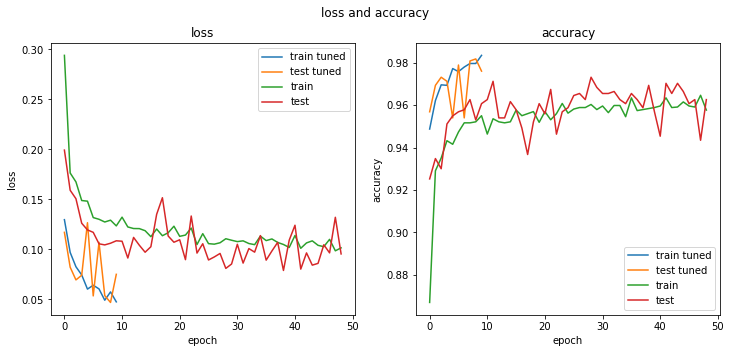

In [ ]:
fig, (ax1, ax2) = plt.subplots(1,2, figsize=(12,5))
ax1.plot(history_resnet50_tuning['loss'])
ax1.plot(history_resnet50_tuning['val_loss'])
ax1.plot(history_resnet50['loss'])
ax1.plot(history_resnet50['val_loss'])
ax1.set_title('loss')
ax1.set_ylabel('loss')
ax1.set_xlabel('epoch')
ax1.legend(['train tuned', 'test tuned','train','test'], loc='upper right')
ax2.plot(history_resnet50_tuning['accuracy'])
ax2.plot(history_resnet50_tuning['val_accuracy'])
ax2.plot(history_resnet50['accuracy'])
ax2.plot(history_resnet50['val_accuracy'])

ax2.set_title('accuracy')
ax2.set_ylabel('accuracy')
ax2.set_xlabel('epoch')
ax2.legend(['train tuned', 'test tuned','train','test'], loc='lower right')
fig.suptitle('loss and accuracy')
plt.show()

In [ ]:
results['model'].append('resnet50')
results['total_param'].append(23598403)
results['time'].append(runtime)
results['score'].append(score[1])
np.save(cwd+'/assets/results.npy', results)

In [ ]:
STEP_SIZE_TEST=test_generator.n//test_generator.batch_size
test_generator.reset()
preds = model.predict(test_generator,
steps=STEP_SIZE_TEST,
verbose=1)

624/624 [==============================] - 6s 9ms/step


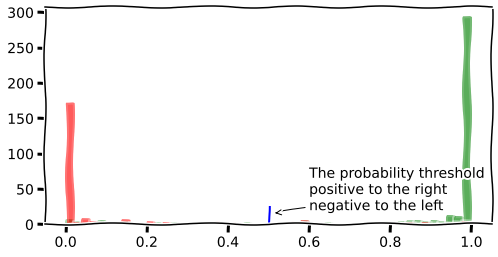

In [ ]:
#scale the output of the model to [0,1]
#scaled_preds=(preds[:,1]-min(preds[:,1]))/(max(preds[:,1])-min(preds[:,1]))
pos = [i for i, j in zip(preds[:,1], test_generator.classes) if j == 1]
neg = [i for i, j in zip(preds[:,1], test_generator.classes) if j == 0]

with plt.xkcd():
  fig = plt.figure(figsize=(8, 4))

  sns.distplot(pos, hist = True, kde = False, color='g',
                 kde_kws = {'shade': True, 'linewidth': 3})

  sns.distplot(neg, hist = True, kde = False, color='r',
                 kde_kws = {'shade': True, 'linewidth': 3})

  plt.plot([0.5, 0.5], [0, 25], '-b')
  plt.annotate(
        'The probability threshold\npositive to the right\nnegative to the left',
        xy=(0.51, 15), arrowprops=dict(arrowstyle='->'), xytext=(0.6, 20))

plt.show()

In [ ]:
confusion = confusion_matrix(test_generator.classes, np.where(preds[:,1]>0.5,1,0), labels=[1, 0])
print(confusion)

[[356  34]
 [ 24 210]]


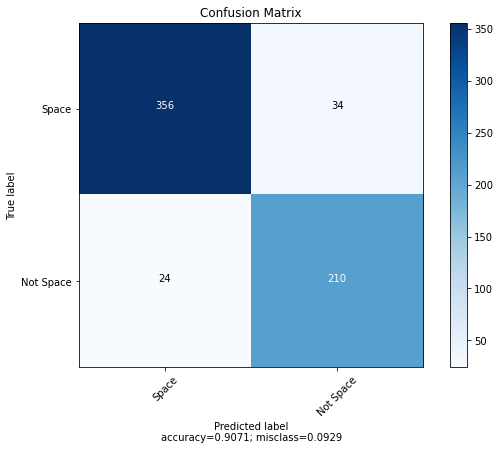

In [ ]:
plot_confusion_matrix(cm=confusion, target_names = ['Space', 'Not Space'], title = 'Confusion Matrix',normalize=False)

In [ ]:
target_names = ['negative', 'positive']
print(classification_report(test_generator.classes, np.where(preds[:,1]>0.5,1,0) , target_names=target_names))

              precision    recall  f1-score   support

    negative       0.86      0.90      0.88       234
    positive       0.94      0.91      0.92       390

    accuracy                           0.91       624
   macro avg       0.90      0.91      0.90       624
weighted avg       0.91      0.91      0.91       624



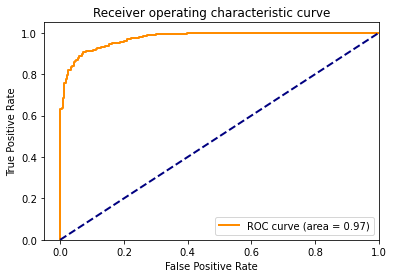

In [ ]:
fpr, tpr, _ = roc_curve(test_generator.classes, preds[:,1])
roc_auc = auc(fpr, tpr)
plt.figure()
lw = 2
plt.plot(fpr, tpr, color='darkorange',
lw=lw, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([-0.05, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic curve')
plt.legend(loc="lower right")
plt.show()

# VGG16

In [ ]:
#data augmentation
train_gen = ImageDataGenerator(
        dtype = 'float32',
   #    featurewise_center=False,  # set input mean to 0 over the dataset
   #    samplewise_center=False,  # set each sample mean to 0
   #    featurewise_std_normalization=False,  # divide inputs by std of the dataset
   #    samplewise_std_normalization=False,  # divide each input by its std
        zca_whitening=False,  # apply ZCA whitening
        rotation_range = 30,  # randomly rotate images in the range (degrees, 0 to 180)
        zoom_range = 0.4, # Randomly zoom image 
        width_shift_range=0.1,  # randomly shift images horizontally (fraction of total width)
        height_shift_range=0.1,  # randomly shift images vertically (fraction of total height)
        horizontal_flip = True,  # randomly flip images
        vertical_flip=False,
        preprocessing_function=tf.keras.applications.vgg16.preprocess_input,
        validation_split=0.2) #validation size
test_gen=ImageDataGenerator(
        dtype = 'float32',
        featurewise_center=False,  # set input mean to 0 over the dataset
        samplewise_center=False,  # set each sample mean to 0
        featurewise_std_normalization=False,  # divide inputs by std of the dataset
        samplewise_std_normalization=False,  # divide each input by its std
        zca_whitening=False,  # apply ZCA whitening
        horizontal_flip = False,  # randomly flip images
        preprocessing_function=tf.keras.applications.vgg16.preprocess_input,
        vertical_flip=False)  # randomly flip images

In [ ]:
batch_size=64
nb_epochs=90
train_generator = train_gen.flow_from_directory(
    wd+"/train",
    batch_size=batch_size,
    target_size=(224, 224), #class_mode="binary"
  #  class_mode='binary',
    subset='training'                                            
)

validation_generator = train_gen.flow_from_directory(
    wd+"/train", # same directory as training data
    batch_size=batch_size,
    target_size=(224, 224),
 #   class_mode='binary',
    subset='validation') # set as validation data
test_generator=test_gen.flow_from_directory(
    wd+"/test", # same directory as training data
    batch_size=1,
    target_size=(224, 224),
    shuffle=False)

Found 4173 images belonging to 2 classes.
Found 1043 images belonging to 2 classes.
Found 624 images belonging to 2 classes.


In [ ]:
inputs = tf.keras.Input(shape=(224,224,3))
##First, instantiate a base model with pre-trained weights.
base_model = tf.keras.applications.VGG16(
    weights="imagenet",  # Load weights pre-trained on ImageNet.
    input_shape=(224,224,3),
    include_top=False,
    pooling='avg',
    input_tensor=inputs
)  # Do not include the ImageNet classifier at the top.

# Freeze the base_model
base_model.trainable = False

# Create new model on top

early_stopping_cb = tf.keras.callbacks.EarlyStopping(patience=10,restore_best_weights=True)
model=Sequential()
model.add(base_model)
model.add(Flatten())
model.add(BatchNormalization())
model.add(Dense(128,activation='relu'))
model.add(Dropout(0.5))
model.add(BatchNormalization())
model.add(Dense(64,activation='relu'))
model.add(Dropout(0.5))
model.add(BatchNormalization())
model.add(Dense(2,activation='softmax'))

model.summary()
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
start=time.time()
history_vgg16 = model.fit_generator(train_generator,epochs=90,validation_data=validation_generator,callbacks=[early_stopping_cb])
runtime=time.time()-start

58892288/58889256 [==============================] - 138s 2us/step
Model: "sequential_17"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Functional)           (None, 512)               14714688  
_________________________________________________________________
flatten_17 (Flatten)         (None, 512)               0         
_________________________________________________________________
batch_normalization_33 (Batc (None, 512)               2048      
_________________________________________________________________
dense_60 (Dense)             (None, 128)               65664     
_________________________________________________________________
dropout_15 (Dropout)         (None, 128)               0         
_________________________________________________________________
batch_normalization_34 (Batc (None, 128)               512       
____________________________________________________

2021-08-15 16:30:57.639008: W tensorflow/core/common_runtime/bfc_allocator.cc:248] Allocator (GPU_0_bfc) ran out of memory trying to allocate 3.46GiB with freed_by_count=0. The caller indicates that this is not a failure, but may mean that there could be performance gains if more memory were available.


66/66 [==============================] - 106s 1s/step - loss: 0.7699 - accuracy: 0.6566 - val_loss: 1.1946 - val_accuracy: 0.6261
Epoch 2/90
66/66 [==============================] - 73s 1s/step - loss: 0.3752 - accuracy: 0.8584 - val_loss: 0.3569 - val_accuracy: 0.8792
Epoch 3/90
66/66 [==============================] - 74s 1s/step - loss: 0.2759 - accuracy: 0.8960 - val_loss: 0.2283 - val_accuracy: 0.9271
Epoch 4/90
66/66 [==============================] - 74s 1s/step - loss: 0.2371 - accuracy: 0.9103 - val_loss: 0.1751 - val_accuracy: 0.9348
Epoch 5/90
66/66 [==============================] - 73s 1s/step - loss: 0.2212 - accuracy: 0.9171 - val_loss: 0.1488 - val_accuracy: 0.9473
Epoch 6/90
66/66 [==============================] - 72s 1s/step - loss: 0.2149 - accuracy: 0.9177 - val_loss: 0.1332 - val_accuracy: 0.9511
Epoch 7/90
66/66 [==============================] - 72s 1s/step - loss: 0.1989 - accuracy: 0.9281 - val_loss: 0.1420 - val_accuracy: 0.9425
Epoch 8/90
66/66 [============

In [ ]:
#saving the model and histories
#tf.keras.models.save_model(filepath=cwd, model=model)
model.save(cwd+'/assets/model_vgg16')
np.save(cwd+'/assets/history_vgg16.npy', history_vgg16.history)
#np.save(cwd+'/assets/history_xception_tuning.npy', history_xception_tuning.history)

INFO:tensorflow:Assets written to: /home/jovyan/work/fc_project/assets/model_vgg16/assets


In [ ]:
#tuning
# Unfreeze the base_model. Note that it keeps running in inference mode
# since we passed `training=False` when calling it. This means that
# the batchnorm layers will not update their batch statistics.
# This prevents the batchnorm layers from undoing all the training
# we've done so far.
base_model.trainable = True
model.summary()

model.compile(
    optimizer=tf.keras.optimizers.Adam(1e-5),  # Low learning rate
    loss='categorical_crossentropy',
    metrics=['accuracy'],
)

epochs = 10

Model: "sequential_17"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Functional)           (None, 512)               14714688  
_________________________________________________________________
flatten_17 (Flatten)         (None, 512)               0         
_________________________________________________________________
batch_normalization_33 (Batc (None, 512)               2048      
_________________________________________________________________
dense_60 (Dense)             (None, 128)               65664     
_________________________________________________________________
dropout_15 (Dropout)         (None, 128)               0         
_________________________________________________________________
batch_normalization_34 (Batc (None, 128)               512       
_________________________________________________________________
dense_61 (Dense)             (None, 64)              

In [ ]:
start=time.time()
history_vgg16_tuning = model.fit_generator(train_generator,epochs=10,validation_data=validation_generator)
runtime=time.time()-start+runtime

Epoch 1/10
66/66 [==============================] - 99s 1s/step - loss: 0.1276 - accuracy: 0.9570 - val_loss: 0.1298 - val_accuracy: 0.9549
Epoch 2/10
66/66 [==============================] - 73s 1s/step - loss: 0.1094 - accuracy: 0.9586 - val_loss: 0.1634 - val_accuracy: 0.9377
Epoch 3/10
66/66 [==============================] - 74s 1s/step - loss: 0.0909 - accuracy: 0.9626 - val_loss: 0.0751 - val_accuracy: 0.9674
Epoch 4/10
66/66 [==============================] - 74s 1s/step - loss: 0.0801 - accuracy: 0.9740 - val_loss: 0.0944 - val_accuracy: 0.9645
Epoch 5/10
66/66 [==============================] - 74s 1s/step - loss: 0.0833 - accuracy: 0.9712 - val_loss: 0.1683 - val_accuracy: 0.9348
Epoch 6/10
66/66 [==============================] - 74s 1s/step - loss: 0.0749 - accuracy: 0.9761 - val_loss: 0.1139 - val_accuracy: 0.9540
Epoch 7/10
66/66 [==============================] - 74s 1s/step - loss: 0.0656 - accuracy: 0.9803 - val_loss: 0.0748 - val_accuracy: 0.9703
Epoch 8/10
66/66 [==

In [ ]:
#saving the model and histories
#tf.keras.models.save_model(filepath=cwd, model=model)
model.save(cwd+'/assets/model_vgg16_tuning')
np.save(cwd+'/assets/history_vgg16_tuning.npy', history_vgg16_tuning.history)
#np.save(cwd+'/assets/history_xception_tuning.npy', history_xception_tuning.history)

INFO:tensorflow:Assets written to: /home/jovyan/work/fc_project/assets/model_vgg16_tuning/assets


In [ ]:
score = model.evaluate(test_generator,  verbose=0)
print('Test score:', score[0])
print('Test accuracy:', score[1])


Test score: 0.17918924987316132
Test accuracy: 0.9294871687889099


In [ ]:
results['model'].append('vgg16')
results['total_param'].append(14791146)
results['time'].append(runtime)
results['score'].append(score[1])
np.save(cwd+'/assets/results.npy', results)

In [ ]:
STEP_SIZE_TEST=test_generator.n//test_generator.batch_size
test_generator.reset()
preds = model.predict(test_generator,
steps=STEP_SIZE_TEST,
verbose=1)

624/624 [==============================] - 5s 8ms/step


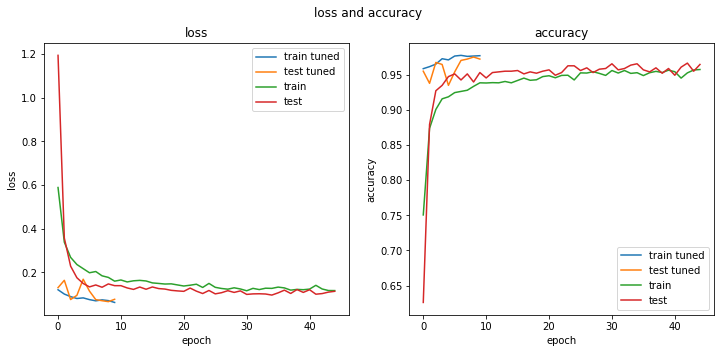

In [ ]:
fig, (ax1, ax2) = plt.subplots(1,2, figsize=(12,5))
ax1.plot(history_vgg16_tuning.history['loss'])
ax1.plot(history_vgg16_tuning.history['val_loss'])
ax1.plot(history_vgg16.history['loss'])
ax1.plot(history_vgg16.history['val_loss'])
ax1.set_title('loss')
ax1.set_ylabel('loss')
ax1.set_xlabel('epoch')
ax1.legend(['train tuned', 'test tuned','train','test'], loc='upper right')
ax2.plot(history_vgg16_tuning.history['accuracy'])
ax2.plot(history_vgg16_tuning.history['val_accuracy'])
ax2.plot(history_vgg16.history['accuracy'])
ax2.plot(history_vgg16.history['val_accuracy'])

ax2.set_title('accuracy')
ax2.set_ylabel('accuracy')
ax2.set_xlabel('epoch')
ax2.legend(['train tuned', 'test tuned','train','test'], loc='lower right')
fig.suptitle('loss and accuracy')
plt.show()

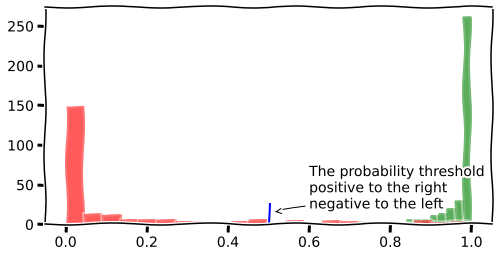

In [ ]:
#scale the output of the model to [0,1]
#scaled_preds=(preds[:,1]-min(preds[:,1]))/(max(preds[:,1])-min(preds[:,1]))
pos = [i for i, j in zip(preds[:,1], test_generator.classes) if j == 1]
neg = [i for i, j in zip(preds[:,1], test_generator.classes) if j == 0]

with plt.xkcd():
  fig = plt.figure(figsize=(8, 4))

  sns.distplot(pos, hist = True, kde = False, color='g',
                 kde_kws = {'shade': True, 'linewidth': 3})

  sns.distplot(neg, hist = True, kde = False, color='r',
                 kde_kws = {'shade': True, 'linewidth': 3})

  plt.plot([0.5, 0.5], [0, 25], '-b')
  plt.annotate(
        'The probability threshold\npositive to the right\nnegative to the left',
        xy=(0.51, 15), arrowprops=dict(arrowstyle='->'), xytext=(0.6, 20))

plt.show()

In [ ]:
confusion = confusion_matrix(test_generator.classes, np.where(preds[:,1]>0.5,1,0), labels=[1, 0])
print(confusion)

[[373  17]
 [ 27 207]]


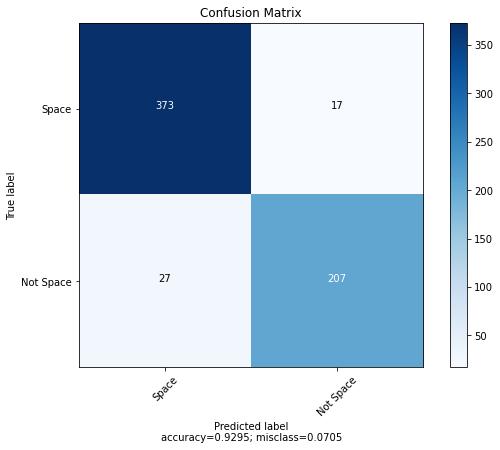

In [ ]:
plot_confusion_matrix(cm=confusion, target_names = ['Space', 'Not Space'], title = 'Confusion Matrix',normalize=False)

In [ ]:
target_names = ['negative', 'positive']
print(classification_report(test_generator.classes, np.where(preds[:,1]>0.5,1,0) , target_names=target_names))

              precision    recall  f1-score   support

    negative       0.92      0.88      0.90       234
    positive       0.93      0.96      0.94       390

    accuracy                           0.93       624
   macro avg       0.93      0.92      0.92       624
weighted avg       0.93      0.93      0.93       624



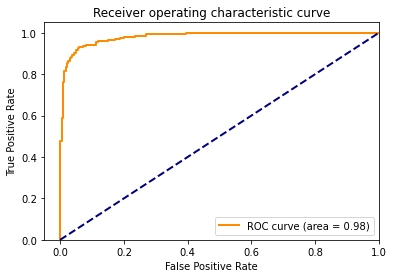

In [ ]:
fpr, tpr, _ = roc_curve(test_generator.classes, preds[:,1])
roc_auc = auc(fpr, tpr)
plt.figure()
lw = 2
plt.plot(fpr, tpr, color='darkorange',
lw=lw, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([-0.05, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic curve')
plt.legend(loc="lower right")
plt.show()

In [185]:
results=np.load(os.getcwd()+'/assets/results.npy', allow_pickle=True)
d = dict(enumerate(results.flatten(), 1))[1]
results=pd.DataFrame.from_dict(d).drop(index=1)
results.iloc[1,0]='xception'



In [186]:
results

,model,total_param,time,score
0,base_model,6819458,2028.689892,0.807692
2,xception,20863536,3776.038816,0.932692
3,resnet50,23598403,4258.521009,0.908654
4,vgg16,14791146,4042.178764,0.929487


<function matplotlib.pyplot.show(close=None, block=None)>

<Figure size 800x480 with 0 Axes>

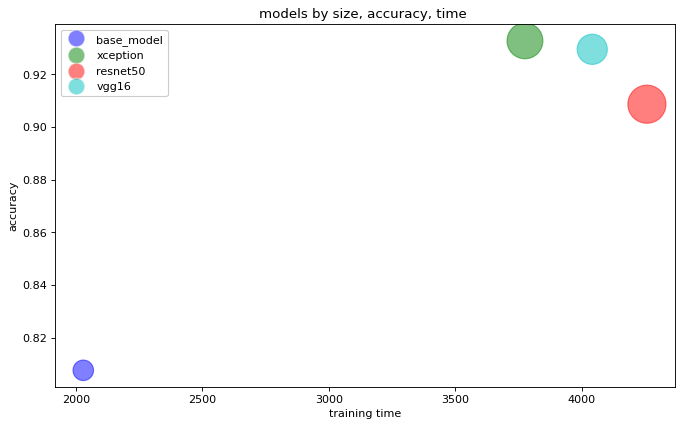

In [244]:
from matplotlib.lines import Line2D
plt.figure(figsize=(10, 6), dpi=80)
plt.figure(figsize=(10, 6), dpi=80)
colors = ['b','g','r','c']
plt.scatter(results['time'],results['score'], s=results['total_param']/20000, alpha=0.5, label=results['model'], c=colors)
legend_elements = [Line2D([0], [0], marker='o', color='w', label=x ,markerfacecolor=y, markersize=15,alpha=0.5) 
                   for (x, y) in list(zip(results['model'], colors))]

plt.legend(handles=legend_elements, framealpha=1, frameon=True, loc='upper left')
plt.xlabel('training time')
plt.ylabel('accuracy')
plt.title('models by size, accuracy, time ')
plt.show



